In [ ]:
from google.colab import drive
drive.mount('/content/drive')
dir_path = '/content/drive/MyDrive/INM707_DRL_CW' # directory path
import sys
sys.path.append(dir_path)

Mounted at /content/drive


# Install dependencies

In [ ]:
# To be able to run our Atari examples, we should install:
!pip install gym[atari,accept-rom-license]==0.19.0

     |████████████████████████████████| 1.6 MB 8.3 MB/s 
     |████████████████████████████████| 2.8 MB 41.8 MB/s 
Reason for being yanked: re-release with new wheels
  Created wheel for gym: filename=gym-0.19.0-py3-none-any.whl size=1663118 sha256=ea29af23ea75c6ce9459c7d4f07c2e236f7546ba27f087fe31e667115a26c714
  Stored in directory: /root/.cache/pip/wheels/ef/9d/70/8bea53f7edec2fdb4f98d9d64ac9f11aea95dfcb98099d7712
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.17.3
    Uninstalling gym-0.17.3:
      Successfully uninstalled gym-0.17.3
  Attempting uninstall: atari-py
    Found existing installation: atari-py 0.2.9
    Uninstalling atari-py-0.2.9:
      Successfully uninstalled atari-py-0.2.9


In [ ]:
# only version that works in Google Colab without any erros
!pip install 'ray[rllib]'==1.6

     |████████████████████████████████| 49.6 MB 28 kB/s 
     |████████████████████████████████| 226 kB 20.5 MB/s 
     |████████████████████████████████| 1.2 MB 54.7 MB/s 
     |████████████████████████████████| 125 kB 47.8 MB/s 


In [ ]:
import os
os.cpu_count()

2

## Import Libraries

In [ ]:
import numpy as np # NumPy functions
import pandas as pd # Dataframe functionalities
import gym # OpenAI gym environments

# Ray and RLlib imports
import ray
import ray.tune as tune
from ray.tune import grid_search
import ray.rllib.agents.dqn as dqn

# Output print
from ray.tune.logger import pretty_print
import pprint

# functions of high-level operations on files and collections of files.
import shutil

# Visualization
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Image

In [ ]:
env = gym.make('PongDeterministic-v4')

In [ ]:
# action space
env.action_space

Discrete(6)

In [ ]:
# action space dictionary
env.unwrapped.get_action_meanings()

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

The observation space is an RGB image (red, green and blue values for each pixes) of the screen, displayed at a resolution of 210 by 60 pixels, with 128 possible colors for each pixel. 

In [ ]:
# observation space
env.observation_space.shape

(210, 160, 3)

In [ ]:
checkpoint_root = "root/ray_results" # assign where we store snapshots of progress, which it will have put in ray_results inside our root directory. 
shutil.rmtree(checkpoint_root, ignore_errors=True, onerror=None)   # clean up old runs from the ray_results folder

Overview of the default DQNTrainer config using the Python Library’s pretty-printing module:

In [ ]:
pprint.pprint(dqn.DEFAULT_CONFIG) 

{'_fake_gpus': False,
 'action_space': None,
 'actions_in_input_normalized': False,
 'adam_epsilon': 1e-08,
 'batch_mode': 'truncate_episodes',
 'before_learn_on_batch': None,
 'buffer_size': 50000,
 'callbacks': <class 'ray.rllib.agents.callbacks.DefaultCallbacks'>,
 'clip_actions': False,
 'clip_rewards': None,
 'collect_metrics_timeout': 180,
 'compress_observations': False,
 'create_env_on_driver': False,
 'custom_eval_function': None,
 'custom_resources_per_worker': {},
 'double_q': True,
 'dueling': True,
 'eager_tracing': False,
 'env': None,
 'env_config': {},
 'env_task_fn': None,
 'evaluation_config': {'explore': False},
 'evaluation_interval': None,
 'evaluation_num_episodes': 10,
 'evaluation_num_workers': 0,
 'evaluation_parallel_to_training': False,
 'exploration_config': {'epsilon_timesteps': 10000,
                        'final_epsilon': 0.02,
                        'initial_epsilon': 1.0,
                        'type': 'EpsilonGreedy'},
 'explore': True,
 'extra_pyt

In [ ]:
config = dqn.DEFAULT_CONFIG.copy()
config['env'] = "PongDeterministic-v4"
config["framework"] = "torch"                                   # default 'tf'
config['num_gpus'] = 1                                          # default 0
config['lr'] = 1e-4                                           # default 0.0005
config['learning_starts'] = 10000                               # default 1000
config['hiddens'] = [512]                                        # defaul 256
# Provide a dict specifying the Exploration object's config.
config['exploration_config'] = {
        # modified parameters for the Exploration class' constructor:
        "epsilon_timesteps": 200000,                           # default 10000
        "final_epsilon": 0.01,                                  # default 0.02
        }
config['target_network_update_freq'] = 10000                    # default 500
config['model'] = {"dim": 42}                                   # default 84
# config['double_q'] = False


In [ ]:
config

{'_fake_gpus': False,
 'action_space': None,
 'actions_in_input_normalized': False,
 'adam_epsilon': 1e-08,
 'batch_mode': 'truncate_episodes',
 'before_learn_on_batch': None,
 'buffer_size': 50000,
 'callbacks': ray.rllib.agents.callbacks.DefaultCallbacks,
 'clip_actions': False,
 'clip_rewards': None,
 'collect_metrics_timeout': 180,
 'compress_observations': False,
 'create_env_on_driver': False,
 'custom_eval_function': None,
 'custom_resources_per_worker': {},
 'double_q': True,
 'dueling': True,
 'eager_tracing': False,
 'env': 'PongDeterministic-v4',
 'env_config': {},
 'env_task_fn': None,
 'evaluation_config': {'explore': False},
 'evaluation_interval': None,
 'evaluation_num_episodes': 10,
 'evaluation_num_workers': 0,
 'evaluation_parallel_to_training': False,
 'exploration_config': {'epsilon_timesteps': 200000, 'final_epsilon': 0.01},
 'explore': True,
 'extra_python_environs_for_driver': {},
 'extra_python_environs_for_worker': {},
 'fake_sampler': False,
 'final_prioritiz

In [ ]:
config = dqn.DEFAULT_CONFIG.copy()
config['env'] = "PongDeterministic-v4"
config["framework"] = "torch"                                   # default 'tf'
config['num_gpus'] = 1                                          # default 0
config['lr'] = .0001                                            # default 0.0005
config['learning_starts'] = 10000                               # default 1000
config['hiddens'] = [512]                                       # defaul 256
# Provide a dict specifying the Exploration object's config.
config['exploration_config'] = {
        # modified parameters for the Exploration class' constructor:
        "epsilon_timesteps": 200000,                           # default 10000
        "final_epsilon": 0.01,                                  # default 0.02
        }

In [ ]:
%timeit

trainer = dqn.DQNTrainer(config=config)

N_ITER = 850
mean_rewards = []
max_rewards = []
min_rewards = []
mean_len = []



for n in range(N_ITER):
    result = trainer.train()
    # print(pretty_print(result))
    mean_rewards.append(result["episode_reward_mean"])
    max_rewards.append(result["episode_reward_max"])
    min_rewards.append(result["episode_reward_min"])
    mean_len.append(result["episode_len_mean"])
    
    if n % 10 == 0:
        checkpoint = trainer.save()
        print("checkpoint saved at", checkpoint)
    if mean_rewards == 20.0:
      break

    print(f'{n+1:3d}. REWARDS [MIN: {result["episode_reward_min"]:8.4f}, MEAN: {result["episode_reward_mean"]:8.4f}, MAX: {result["episode_reward_max"]:8.4f}] MEAN_LEN: {result["episode_len_mean"]:8.4f}.')



2022-04-23 01:08:39,590	WARNING util.py:55 -- Install gputil for GPU system monitoring.


checkpoint saved at /root/ray_results/DQN_PongDeterministic-v4_2022-04-23_01-08-39mrmt_61j/checkpoint_000001/checkpoint-1
  1. REWARDS [MIN: -21.0000, MEAN: -20.6000, MAX: -19.0000] MEAN_LEN: 932.6000.
  2. REWARDS [MIN: -21.0000, MEAN: -20.6364, MAX: -19.0000] MEAN_LEN: 924.2727.
  3. REWARDS [MIN: -21.0000, MEAN: -20.5000, MAX: -19.0000] MEAN_LEN: 927.5000.
  4. REWARDS [MIN: -21.0000, MEAN: -20.4615, MAX: -19.0000] MEAN_LEN: 923.1538.
  5. REWARDS [MIN: -21.0000, MEAN: -20.4286, MAX: -19.0000] MEAN_LEN: 921.6429.
  6. REWARDS [MIN: -21.0000, MEAN: -20.4667, MAX: -19.0000] MEAN_LEN: 911.1333.
  7. REWARDS [MIN: -21.0000, MEAN: -20.5000, MAX: -19.0000] MEAN_LEN: 908.0000.
  8. REWARDS [MIN: -21.0000, MEAN: -20.4706, MAX: -19.0000] MEAN_LEN: 911.2353.
  9. REWARDS [MIN: -21.0000, MEAN: -20.4444, MAX: -19.0000] MEAN_LEN: 911.6667.
 10. REWARDS [MIN: -21.0000, MEAN: -20.4500, MAX: -19.0000] MEAN_LEN: 918.8000.
checkpoint saved at /root/ray_results/DQN_PongDeterministic-v4_2022-04-23_01-0

In [ ]:
df_pong_dqn_results = pd.DataFrame(list(zip(max_rewards, min_rewards, mean_rewards, mean_len)),columns =['max_rewards', 'min_rewards', 'mean_rewards', 'mean_len'])
df_pong_dqn_results.to_csv('/content/drive/MyDrive/INM707_DRL_CW/df_pong_dqn_results.csv', index=False)

In [ ]:
x = np.arange(N_ITER)
fig = plt.figure(figsize=(10,7))
plt.plot(max_rewards, label = "reward_max", color = "red")
plt.plot(min_rewards, label = "reward_min", color = "green")
plt.plot(mean_rewards, label = "reward_mean", color = "blue")

plt.legend(loc = "upper left")
plt.fill_between(x, max_rewards, min_rewards,
                 facecolor="orange", # The fill color
                 color='blue',       # The outline color
                 alpha=0.2)          # Transparency of the fill

plt.ylabel("Reward")
plt.xlabel("TimeStep/Iteration")

fig.savefig('/content/drive/MyDrive/INM707_DRL_CW/dqn_results_pong.png')

<Figure size 720x504 with 1 Axes>


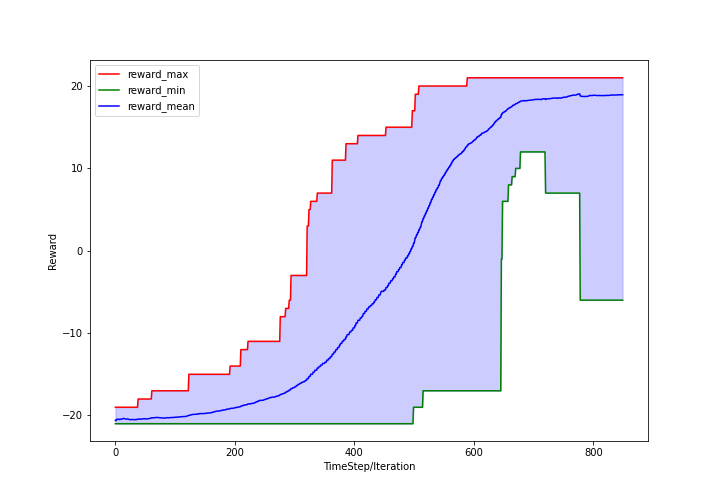

In [ ]:
Image('/content/drive/MyDrive/INM707_DRL_CW/dqn_results_pong.png')